In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pathlib

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from ncc import ncc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CUDA Device Properties
Addressable from python directly

In [3]:
device_props = cp.cuda.runtime.getDeviceProperties(0)
device_props

{'name': b'NVIDIA GeForce RTX 2070',
 'totalGlobalMem': 8589475840,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim': (1024, 1024, 64),
 'maxGridSize': (2147483647, 65535, 65535),
 'clockRate': 1740000,
 'totalConstMem': 65536,
 'major': 7,
 'minor': 5,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'multiProcessorCount': 36,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture2D': (131072, 65536),
 'maxTexture3D': (16384, 16384, 16384),
 'concurrentKernels': 1,
 'ECCEnabled': 0,
 'pciBusID': 158,
 'pciDeviceID': 0,
 'pciDomainID': 0,
 'tccDriver': 0,
 'memoryClockRate': 7001000,
 'memoryBusWidth': 256,
 'l2CacheSize': 4194304,
 'maxThreadsPerMultiProcessor': 1024,
 'isMultiGpuBoard': 0,
 'cooperativeLaunch': 1,
 'cooperativeMultiDeviceLaunch': 0,
 'deviceOverlap': 1,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 '

## Cross-Correlation Types

#### Standard Normalized Cross Correlation
$r_{xy}=\frac{\sum{(x_i-\bar{x})(y_i-\bar{y})}}
{\sqrt{\sum{(x_i-\bar{x})^2}}
\sqrt{\sum{(y_i-\bar{y})^2}}}$

- More stable numerically
- $k*k$ loops required (first k computes means, second k computes r)

#### Single Pass Normalized Cross Correlation
$r_{xy}=\frac{ n\sum{x_iy_i} - \sum{x_i}\sum{yi} }
{ \sqrt{n\sum{x^2_i}-(\sum{x_i})^2}
\sqrt{n\sum{y^2_i}-(\sum{y_i})^2}}$

- Less stable numericall (denominator prone to cancellation when r close to 1)
- Can be computed in only k loops 

## Load Sample RF Data File 

In [4]:
from ncc_utils import load_test_data

# Load rfd data and metadata
paths = {
    'data': './rfd.mat',
}
print(f"Loading RFD from : {paths['data']}")
rf_dict, coords, initialData = load_test_data(paths['data'])

# Upsample rf data along fast time dimension
rf = rf_dict['arfi'].astype(np.float32)

Loading RFD from : ..\..\..\data


In [5]:
# Default parameters for ncc 
fc = 4e6                    # transducer center frequency (Hz)
c = 1540                    # speed of sound (m/s)
fs = 40e6                   # sampling frequency (Hz)
fsUpsampleFactor = 4        # rf axial interpolation upsampling factor
axSparsity = 1              # axial samples between each correlation kernel start index
nLambdaKernel = 2           # cross correlation kernel size (n wavelengths)
maxShift = 10e-6            # maximum expected shift in each direction (microns)

ncc_defaults = dict(fc=fc, c=c, fs=fs, fsUpsampleFactor=fsUpsampleFactor, axSparsity=axSparsity, nLambdaKernel=nLambdaKernel, maxShift=maxShift)

In [6]:
def print_and_plot(cc, arfidata, ilat=20):
    print(f"Output CC matrix shape       : {cc.shape}")
    print(f"Output arfidata matrix shape : {arfidata.shape}")
    print(f"Center lateral line frame PD : {np.max(arfidata[:,ilat,:].reshape(-1,)):.2f} um")
    plt.imshow(arfidata[:,ilat,:], aspect='auto')
    plt.colorbar()

def free_gpu_memory():
    # Free GPU Memory
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

## CPU Implementations

Output CC matrix shape       : (2035, 1, 71)
Output arfidata matrix shape : (2035, 1, 71)
Center lateral line frame PD : 11.57 um


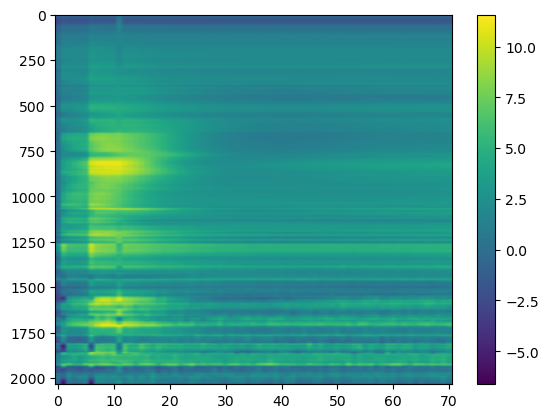

In [8]:
# Standard normalized cross correlation algorithm
cc, arfidata = ncc(rf[:,20,:], mode='standard-cpu', **ncc_defaults)

print_and_plot(cc, arfidata, ilat=0)

Output CC matrix shape       : (2035, 1, 71)
Output arfidata matrix shape : (2035, 1, 71)
Center lateral line frame PD : 11.57 um


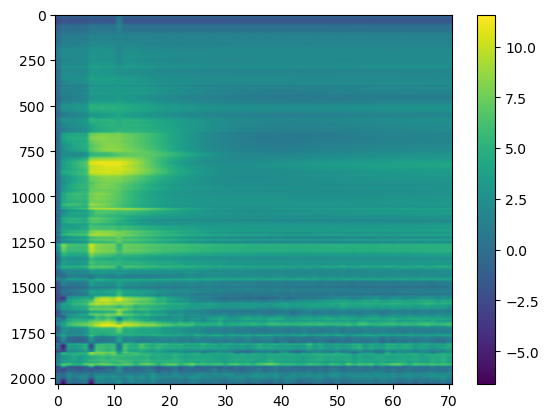

In [9]:
# Single pass normalized cross correlation algorithm
cc, arfidata = ncc(rf[:,20,:], mode='singlepass-cpu', **ncc_defaults)

print_and_plot(cc, arfidata, ilat=0)

## GPU Implementations

In [7]:
# Standard normalized cross correlation algorithm
cc, arfidata = ncc(rf[:,20:24,:], mode='standard-gpu', **ncc_defaults)

print_and_plot(cc, arfidata, ilat=0)

NCC GPU Allocation:
	Block size : (9,)
	Grid size  : (2035, 4, 71)
Total correlation calls = 5201460


NCC GPU Allocation:
	Block size : (9,)
	Grid size  : (2035, 40, 71)
Total correlation calls = 52014600
Pinterp GPU Allocation:
	Block size : (1,)
	Grid size  : (5779400,)
Total pinterp calls = 5779400
Output CC matrix shape       : (2035, 40, 71)
Output arfidata matrix shape : (2035, 40, 71)
Center lateral line frame PD : 11.57 um


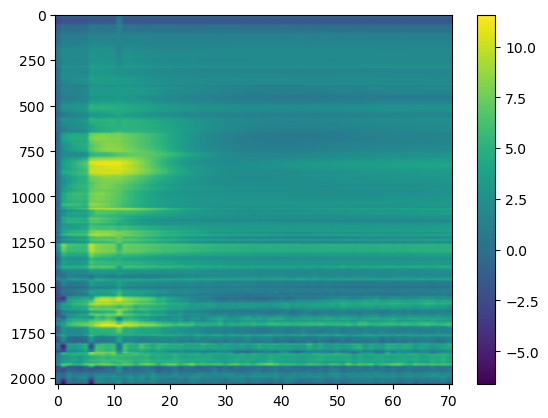

In [20]:
# Single pass normalized cross correlation algorithm
cc, arfidata = ncc(rf, mode='singlepass-gpu', **ncc_defaults)

print_and_plot(cc, arfidata, ilat=20)

NCC GPU Allocation:
	Block size : (9, 71)
	Grid size  : (2035, 40)
Total correlation calls = 52014600
Pinterp GPU Allocation:
	Block size : (1,)
	Grid size  : (5779400,)
Total pinterp calls = 5779400
Output CC matrix shape       : (2035, 40, 71)
Output arfidata matrix shape : (2035, 40, 71)
Center lateral line frame PD : 11.57 um


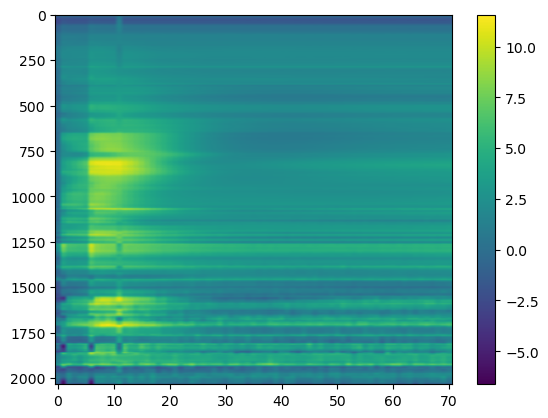

In [23]:
# Standard normalized cross correlation algorithm
# Fast: uses (nshifts, nT-1) blocks to improve caching
# nblocks = nshifts*(nT-1) <= 1024 from CUDA limitation
cc, arfidata = ncc(rf, mode='standard-gpu-fast', **ncc_defaults)

print_and_plot(cc, arfidata, ilat=20)

## Profiling

In [30]:
%%writefile _profile_ncc.py
import pathlib
import numpy as np
import cupy as cp

from ncc import ncc
from ncc_utils import load_test_data

# Setup paths to rfd datasets
paths = dict(home=pathlib.Path.home())
paths['usDatasets'] = paths['home'] / 'data' / 'example-ultrasound-datasets'
paths['dataset'] = paths['usDatasets'] / 'siemens' / 'kidney'

# Load rfd data and metadata
print(f"Loading RFD from : {paths['dataset']}")
rf_dict, coords, initialData = load_test_data(paths['dataset']/'rfd.mat')

# Upsample rf data along fast time dimension
rf = rf_dict['arfi'].astype(np.float32)

# Default parameters for ncc 
fc = 4e6                    # transducer center frequency (Hz)
c = 1540                    # speed of sound (m/s)
fs = 40e6                   # sampling frequency (Hz)
fsUpsampleFactor = 4        # rf axial interpolation upsampling factor
axSparsity = 1              # axial samples between each correlation kernel start index
nLambdaKernel = 2           # cross correlation kernel size (n wavelengths)
maxShift = 10e-6            # maximum expected shift in each direction (microns)

ncc_defaults = dict(fc=fc, c=c, fs=fs, fsUpsampleFactor=fsUpsampleFactor, axSparsity=axSparsity, nLambdaKernel=nLambdaKernel, maxShift=maxShift)

cc, arfidata = ncc(rf, mode='standard-gpu-fast', **ncc_defaults)

Writing _profile_ncc.py


In [31]:
# Free GPU Memory
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

# Call profiler from command line
! nvprof --openacc-profiling off python _profile_ncc.py

# Delete temporary profiling function
pathlib.Path('_profile_ncc.py').unlink()

Loading RFD from : /home/jbr/data/example-ultrasound-datasets/siemens/kidney
==113284== NVPROF is profiling process 113284, command: python _profile_ncc.py
NCC GPU Allocation:
	Block size : (9, 71)
	Grid size  : (2035, 40)
Total correlation calls = 52014600
Pinterp GPU Allocation:
	Block size : (1,)
	Grid size  : (5779400,)
Total pinterp calls = 5779400
==113284== Profiling application: python _profile_ncc.py
==113284== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   81.61%  270.71ms         1  270.71ms  270.71ms  270.71ms  correlate
                    7.30%  24.227ms         1  24.227ms  24.227ms  24.227ms  pinterp
                    4.71%  15.630ms         2  7.8150ms  6.5812ms  9.0488ms  [CUDA memcpy DtoH]
                    3.09%  10.266ms         1  10.266ms  10.266ms  10.266ms  cupy_argmax
                    2.53%  8.3785ms         1  8.3785ms  8.3785ms  8.3785ms  [CUDA memcpy HtoD]
                    0.7